<a href="https://colab.research.google.com/github/Chandan975/Django/blob/main/Time_Series_Modeling_using_Scikit%2C_Pandas%2C_and_Numpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt



In [ ]:
url='https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'
data = pd.read_csv(url,sep=",")

In [ ]:
data.head()

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.184,NaN,NaN,NaN
1,2006-01-02,1380.521,NaN,NaN,NaN
2,2006-01-03,1442.533,NaN,NaN,NaN
3,2006-01-04,1457.217,NaN,NaN,NaN
4,2006-01-05,1477.131,NaN,NaN,NaN


In [ ]:
# to explicitly convert the date column to type DATETIME
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

Defining the Modeling task

#*Goals of Prediction*
Our aim is to predict Consumption (ideally for future unseen dates) from this time series dataset.

#*Training and Test set*
We will be using 10 years of data for training i.e. 2006–2016 and last year’s data for testing i.e. 2017.

#*Performance Measure*
In order to evaluate how good our model is, we would be using R-squared and Root Mean Squared Error (but will be printing all relevant metrics for you to take the final call)

#*Helper Functions*
In order to print all performance metrics relevant to a regression task (such as MAE and R-square), we will be defining the regression_results function.

In [ ]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

#Feature Engineering

#*As a baseline, we choose a simplistic model, one that predicts today’s consumption value based on*

yesterday’s consumption value and;

difference between yesterday and the day before yesterday’s consumption value.

In [ ]:
# creating new dataframe from consumption column
data_consumption = data[['Consumption']]
# inserting new column with yesterday's consumption values
data_consumption.loc[:,'Yesterday'] = data_consumption.loc[:,'Consumption'].shift()
# inserting another column with difference between yesterday and day before yesterday's consumption values.
data_consumption.loc[:,'Yesterday_Diff'] = data_consumption.loc[:,'Yesterday'].diff()
# dropping NAs
data_consumption = data_consumption.dropna()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [ ]:
data_consumption

,Consumption,Yesterday,Yesterday_Diff
Date,,,
2006-01-03,1442.53300,1380.52100,311.33700
2006-01-04,1457.21700,1442.53300,62.01200
2006-01-05,1477.13100,1457.21700,14.68400
2006-01-06,1403.42700,1477.13100,19.91400
2006-01-07,1300.28700,1403.42700,-73.70400
...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345
2017-12-28,1299.86398,1263.94091,133.82408
2017-12-29,1295.08753,1299.86398,35.92307


#Defining training and test sets

In [ ]:
X_train = data_consumption[:'2016'].drop(['Consumption'], axis = 1)
y_train = data_consumption.loc[:'2016', 'Consumption']
X_test = data_consumption['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption.loc['2017', 'Consumption']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#Cross Validation on Time series data

#*A better alternative for cross validation on time series data (than K-fold CV) is Forward Chaining strategy.*

In forward chaining, say with 3 folds, the train and validation sets look like:

fold 1: training [1], validation [2]
fold 2: training [1 2], validation [3]
fold 3: training [1 2 3], validation [4]

where 1, 2, 3, 4 represent the year. This way successive training sets are supersets of those that come before them.


Luckily for us, sklearn has a provision for implementing such train test split using TimeSeriesSplit.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

The TimeSerieSplit function takes as input the number of splits. Since our training data has 11 unique years (2006 -2016), we would be setting n_splits = 10. This way we have neat training and validation sets:


fold 1: training [2006], validation [2007]
fold 2: training [2006 2007], validation [2008]
fold 3: training [2006 2007 2008], validation [2009]
fold 4: training [2006 2007 2008 2009], validation [2010]
fold 5: training [2006 2007 2008 2009 2010], validation [2011]
fold 6: training [2006 2007 2008 2009 2010 2011], validation [2012]
fold 7: training [2006 2007 2008 2009 2010 2011 2012], validation [2013]
fold 8: training [2006 2007 2008 2009 2010 2011 2012 2013], validation [2014]
fold 9: training [2006 2007 2008 2009 2010 2011 2012 2013 2014], validation [2015]
fold 10: training [2006 2007 2008 2009 2010 2011 2012 2013 2014 2015], validation [2016]

#Spot check Algorithms

LR: 0.343747 (0.029773)


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REAC

NN: 0.512419 (0.094369)
KNN: 0.646307 (0.083185)
RF: 0.626612 (0.077498)
SVR: -0.117944 (0.157755)


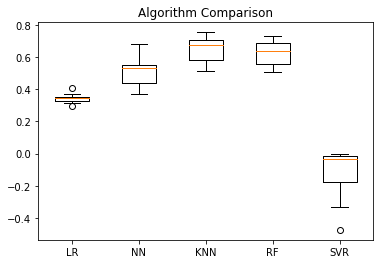

In [ ]:
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=10)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

Both KNN and RF perform equally well. But I personally prefer RF since this ensemble model (combine multiple ‘individual’ (diverse) models together and deliver superior prediction power.) can almost work out of the box and that is one reason why they are very popular.

#*Grid Searching Hyperparameters*

#An optimal combination of hyperparameters maximizes a model’s performance without leading to a high variance problem (overfitting).

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
model = RandomForestRegressor()
param_search={
    'n_estimators':[20,50,100],
    'max_features':['auto','sqrt','log2'],
    'max_depth':[i for i in range(5,15)]
    }

tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train, y_train)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_

NameError: ignored

In [ ]:
from sklearn.metrics import make_scorer
def rmse(actual, predict):
  predict = np.array(predict)
  actual = np.array(actual)
  distance = predict - actual
  square_distance = distance ** 2
  mean_square_distance = square_distance.mean()
  score = np.sqrt(mean_square_distance)
  return score
rmse_score = make_scorer(rmse, greater_is_better = False)

#Checking best model performance on test data

In [ ]:
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

NameError: ignored

#Feature Engineering Returns

Up until now, we have been using values at (t-1)th day to predict values on t date. Now, let us also use values from (t-2)days to predict consumption:

In [ ]:
# creating copy of original dataframe
data_consumption_2o = data_consumption.copy()
# inserting column with yesterday-1 values
data_consumption_2o['Yesterday-1'] = data_consumption_2o['Yesterday'].shift()
# inserting column with difference in yesterday-1 and yesterday-2 values.
data_consumption_2o['Yesterday-1_Diff'] = data_consumption_2o['Yesterday-1'].diff()
# dropping NAs
data_consumption_2o = data_consumption_2o.dropna()

In [ ]:
data_consumption_2o

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff
Date,,,,,
2006-01-05,1477.13100,1457.21700,14.68400,1442.53300,62.01200
2006-01-06,1403.42700,1477.13100,19.91400,1457.21700,14.68400
2006-01-07,1300.28700,1403.42700,-73.70400,1477.13100,19.91400
2006-01-08,1207.98500,1300.28700,-103.14000,1403.42700,-73.70400
2006-01-09,1529.32300,1207.98500,-92.30200,1300.28700,-103.14000
...,...,...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345,1111.28338,-30.47392
2017-12-28,1299.86398,1263.94091,133.82408,1130.11683,18.83345
2017-12-29,1295.08753,1299.86398,35.92307,1263.94091,133.82408


#Resetting the train and test set

In [ ]:
X_train_2o = data_consumption_2o[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o = data_consumption_2o.loc[:'2016', 'Consumption']
X_test = data_consumption_2o['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_2o.loc['2017', 'Consumption']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


#Checking to see if the ‘best’ random forest using ‘new’ predictors performs better

In [ ]:
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o, y_train_2o)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

explained_variance:  0.8375
mean_squared_log_error:  0.0025
r2:  0.8375
MAE:  40.7685
MSE:  4400.0338
RMSE:  66.3328


#Feature Engineering strikes back

In [ ]:
data_consumption_2o_solar = data_consumption_2o.join(data[['Solar']])
data_consumption_2o_solar = data_consumption_2o_solar.dropna()

In [ ]:
data_consumption_2o_solar

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff,Solar
Date,,,,,,
2012-01-01,948.12800,1077.62500,-122.24100,1199.86600,-27.02200,6.587
2012-01-02,1269.58100,948.12800,-129.49700,1077.62500,-122.24100,6.574
2012-01-03,1334.74500,1269.58100,321.45300,948.12800,-129.49700,24.679
2012-01-04,1347.13600,1334.74500,65.16400,1269.58100,321.45300,14.681
2012-01-05,1376.65800,1347.13600,12.39100,1334.74500,65.16400,5.071
...,...,...,...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345,1111.28338,-30.47392,16.530
2017-12-28,1299.86398,1263.94091,133.82408,1130.11683,18.83345,14.162
2017-12-29,1295.08753,1299.86398,35.92307,1263.94091,133.82408,29.854


Resetting Train/Test + GridSearch + Checking performance


In [ ]:
X_train_2o_solar = data_consumption_2o_solar[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o_solar = data_consumption_2o_solar.loc[:'2016', 'Consumption']
X_test = data_consumption_2o_solar['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_2o_solar.loc['2017', 'Consumption']
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o_solar, y_train_2o_solar)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


explained_variance:  0.8439
mean_squared_log_error:  0.0024
r2:  0.8438
MAE:  39.2494
MSE:  4228.6576
RMSE:  65.0281


Variable Importance Plot

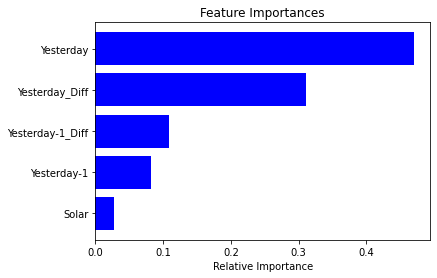

In [ ]:
imp = best_model.feature_importances_
features = X_train_2o_solar.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Feature Engineering Endgame

In [ ]:
data_consumption_2o_solar_weeklyShift = data_consumption_2o_solar.copy()
data_consumption_2o_solar_weeklyShift['Last_Week'] = data_consumption_2o_solar['Consumption'].shift(7)
data_consumption_2o_solar_weeklyShift = data_consumption_2o_solar_weeklyShift.dropna()

In [ ]:
data_consumption_2o_solar_weeklyShift 

,Consumption,Yesterday,Yesterday_Diff,Yesterday-1,Yesterday-1_Diff,Solar,Last_Week
Date,,,,,,,
2012-01-08,1103.38300,1175.68800,-115.52700,1291.21500,-85.44300,8.440,948.12800
2012-01-09,1443.37100,1103.38300,-72.30500,1175.68800,-115.52700,5.264,1269.58100
2012-01-10,1434.63100,1443.37100,339.98800,1103.38300,-72.30500,17.827,1334.74500
2012-01-11,1449.76800,1434.63100,-8.74000,1443.37100,339.98800,10.849,1347.13600
2012-01-12,1442.44800,1449.76800,15.13700,1434.63100,-8.74000,18.023,1376.65800
...,...,...,...,...,...,...,...
2017-12-27,1263.94091,1130.11683,18.83345,1111.28338,-30.47392,16.530,1559.68569
2017-12-28,1299.86398,1263.94091,133.82408,1130.11683,18.83345,14.162,1520.37206
2017-12-29,1295.08753,1299.86398,35.92307,1263.94091,133.82408,29.854,1423.23782


Resetting Train/Test + GridSearch + Checking performance

In [ ]:
X_train_2o_solar_weeklyShift = data_consumption_2o_solar_weeklyShift[:'2016'].drop(['Consumption'], axis = 1)
y_train_2o_solar_weeklyShift = data_consumption_2o_solar_weeklyShift.loc[:'2016', 'Consumption']
X_test = data_consumption_2o_solar_weeklyShift['2017'].drop(['Consumption'], axis = 1)
y_test = data_consumption_2o_solar_weeklyShift.loc['2017', 'Consumption']
model = RandomForestRegressor()
param_search = { 
    'n_estimators': [20, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [i for i in range(5,15)]
}
tscv = TimeSeriesSplit(n_splits=10)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid=param_search, scoring = rmse_score)
gsearch.fit(X_train_2o_solar_weeklyShift, y_train_2o_solar_weeklyShift)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test.values
y_pred = best_model.predict(X_test)
regression_results(y_true, y_pred)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


explained_variance:  0.8941
mean_squared_log_error:  0.0017
r2:  0.8936
MAE:  31.5704
MSE:  2881.6655
RMSE:  53.6811


#Conclusion

we learned how to model time series data, conduct cross-validation on time series data, and fine-tune our model hyperparameters. We also successfully managed to reduce the RMSE from 85.61 to 54.57 for predicting power consumption.